In [344]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [345]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.  # landing platform height
w1 = [-PLATFORM_WIDTH, PLATFORM_WIDTH]
w2 = [0.1*-PLATFORM_WIDTH, 0.1*PLATFORM_WIDTH]
h = [PLATFORM_HEIGHT, PLATFORM_HEIGHT]
ROTATION_ACCEL = np.radians(20)  # rotation constant

In [346]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """

        delta_state_ori = ROTATION_ACCEL* FRAME_TIME*t.tensor([0., 1, 0., 0., 0., 0.])

        sin = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [-1., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.]]),t.sin(t.transpose(state,0,1)))
        cos = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [1., 0., 0., 0., 0., 0.]]),t.cos(t.transpose(state,0,1)))
        cos_sin = cos+sin
        cos_sin = t.transpose(cos_sin,0,1)
        delta_state_pos = BOOST_ACCEL* FRAME_TIME*t.tensor([0., 0., 0., 1., 0., 1.])*cos_sin # x and y components of acceleration

        delta_state_combine = delta_state_ori + delta_state_pos

        action_mat = t.tensor([[0., 0.],
                         [2., 0.],
                         [0., 0.],
                         [0., 1.],
                         [0., 0.],
                         [0., 1.]])

        a_a = t.add(t.transpose(t.matmul(action_mat, t.transpose(action,0,1)),0,1) , t.tensor([0., -1., 0., 0., 0., 0.]))# get ori and pos accelerations

        delta_state = delta_state_combine*a_a

        state_gravity = GRAVITY_ACCEL * FRAME_TIME*t.tensor([0., 0., 0., 0., 0., -1.])
        state = state + delta_state + state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME,],
                             [0., 0., 0., 0., 0., 1.]])
        state = t.transpose(t.matmul(step_mat, t.transpose(state,0,1)),0,1)

        return state

In [347]:
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden1, dim_hidden2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [348]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, N):
        super(Simulation, self).__init__()
        self.state = self.initialize_state(N)
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state(n):
        initial = np.zeros((n,6))
        for i in range(n):
            initial[i] = [0.5*math.pi*(random.random()-0.5), 0.1*math.pi*(random.random()-0.5), # orientation state
                     (random.random()-0.5), 0.1*(random.random()-0.5), # horizontal state
                     0.5*random.random()+1, -0.1*random.random()]  # vertical state
        print(initial)
        return t.tensor(initial, requires_grad=False).float()
    def error(self, state):
        states = t.square(state).sum(dim=0)*t.tensor([1., 1., 0.01, 1., 1., 1.0]) # weight of each state
        return states.sum(dim=0)

In [349]:
class Evaluation:
    def __init__(self, simulation):
        self.simulation = simulation
        # self.parameters = simulation.controller.parameters()

    def test(self, n):
        loss = self.simulation(self.simulation.state)
        print('loss: %.3f' % loss)
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        print('Landing Trajectory:')
        for r in range(n):
            plt.quiver(data[:,r, 2], data[:,r, 4], -0.05*np.sin(data[:,r, 0]), 0.05*np.cos(data[:,r, 0]))
            plt.quiver(data[-1,r, 2], data[-1,r, 4], -0.05*np.sin(data[-1,r, 0]), 0.05*np.cos(data[-1,r, 0]),color='orange')
            plt.plot(w1, h, color="red", linewidth=3)
            plt.plot(w2, h, color="green", linewidth=3)
            plt.show()
            end = data[-1,r,:]
            print(np.abs(end))

[[-0.30608107 -0.09898227  0.0406698  -0.03392526  1.00232811 -0.01422547]
 [-0.01177481  0.14512887  0.1546332  -0.02542362  1.43530623 -0.08426353]
 [ 0.25328151  0.08985696  0.1287229   0.02328819  1.18759904 -0.04819161]
 [-0.72956171  0.15226986 -0.28059933 -0.04153849  1.40860697 -0.03697202]
 [ 0.60869097 -0.02354509 -0.15794128  0.00887401  1.15494616 -0.04151743]
 [-0.62729916 -0.09376529  0.31124791 -0.02495695  1.15677752 -0.00154097]
 [-0.14144791  0.13087435 -0.33539512  0.00841008  1.08980014 -0.07569156]
 [ 0.61046871  0.08384419 -0.34129956  0.04194014  1.196748   -0.07127404]
 [-0.04943671 -0.07827717  0.39222174  0.03259203  1.12616674 -0.02435854]
 [-0.41292289  0.01523503 -0.03666157  0.03955069  1.03361434 -0.08408344]
 [-0.34459578 -0.08264896 -0.32594014  0.01768633  1.24005399 -0.0622193 ]
 [-0.03200031 -0.15582616 -0.43275585  0.02279688  1.39439535 -0.07268111]
 [-0.63913482 -0.11116097  0.3038327  -0.02833962  1.11874262 -0.01258276]
 [-0.24056236  0.02428246

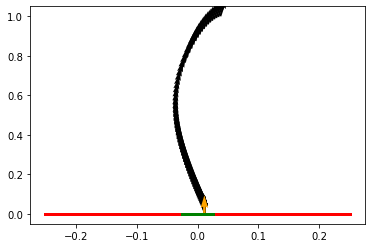

[1.21564015e-04 1.23366146e-04 1.11071886e-02 3.83316219e-04
 1.45100275e-04 5.59370965e-05]


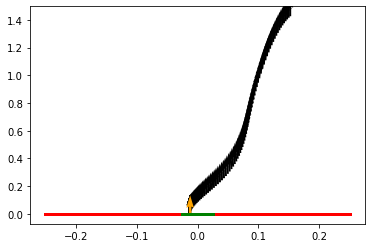

[0.00023742 0.00048236 0.01228312 0.00040784 0.00032638 0.00013649]


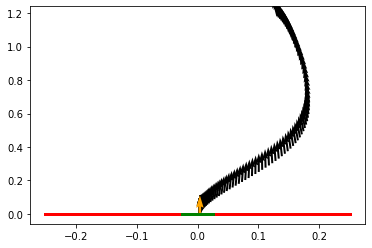

[1.2848944e-04 4.1449632e-04 3.6974701e-03 6.4439155e-05 4.8106027e-04
 3.3356342e-04]


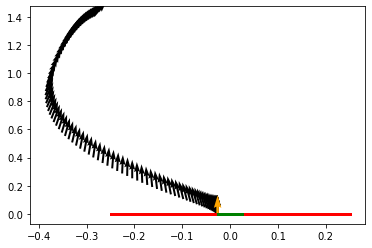

[0.00117289 0.00027345 0.02619555 0.00075698 0.00016576 0.00022474]


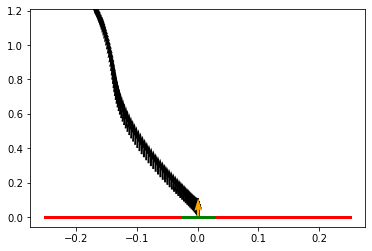

[5.3554738e-04 9.4747782e-05 9.1282214e-04 1.4297044e-04 1.4095382e-04
 1.6125757e-04]


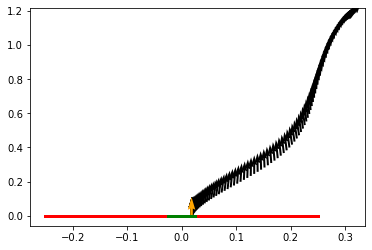

[0.00021606 0.00101724 0.01825956 0.00046031 0.00057702 0.00071509]


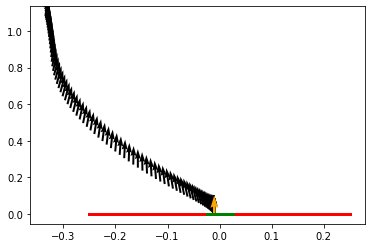

[1.47396844e-04 2.07167250e-05 1.02900285e-02 3.07368318e-04
 2.07746940e-04 6.97579235e-05]


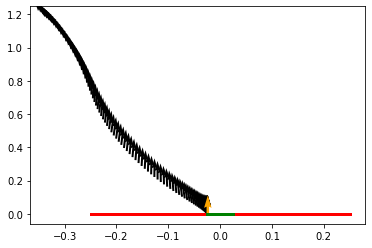

[1.1937595e-03 9.8807691e-04 2.3835592e-02 7.2687730e-04 8.3631503e-06
 8.5909851e-05]


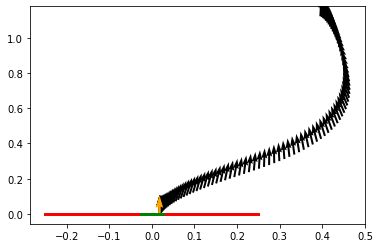

[0.00255711 0.00039635 0.0176813  0.00091803 0.00037115 0.00031057]


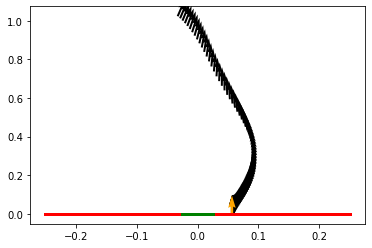

[0.00097119 0.00065231 0.05639544 0.00117001 0.00089524 0.00025959]


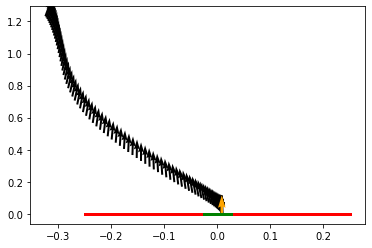

[2.8569612e-04 4.2343893e-04 8.5540833e-03 3.6838261e-04 3.5662142e-05
 2.5502592e-04]


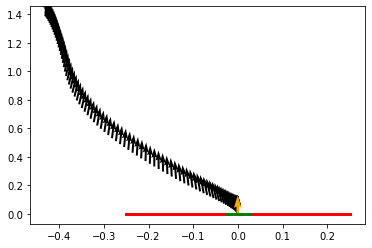

[0.00093069 0.00027803 0.00055625 0.00020425 0.0001598  0.00063535]


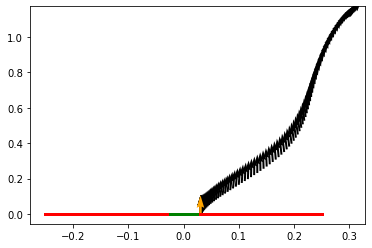

[8.9867928e-05 1.0084101e-03 3.0664688e-02 7.0607790e-04 3.2549581e-04
 7.4397959e-04]


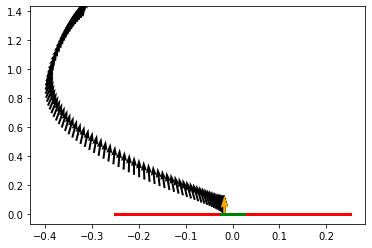

[2.4021046e-04 1.6109608e-04 1.7278831e-02 5.3479790e-04 3.3768360e-05
 2.3209117e-04]


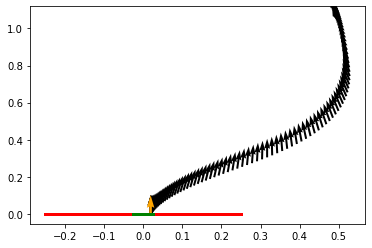

[0.00293747 0.00049136 0.01887288 0.00103553 0.00031937 0.00020912]


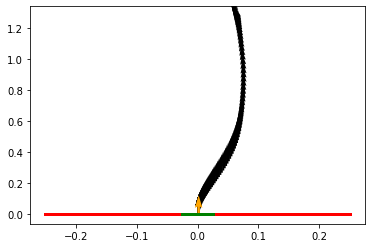

[2.4842436e-04 3.8792499e-04 1.6910291e-03 8.0040700e-05 3.4580962e-04
 1.5165005e-04]


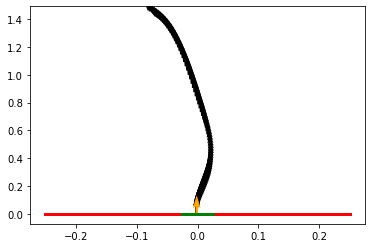

[6.5870275e-04 5.0075236e-05 1.4139388e-03 4.6833808e-05 3.5213813e-04
 2.3442879e-04]


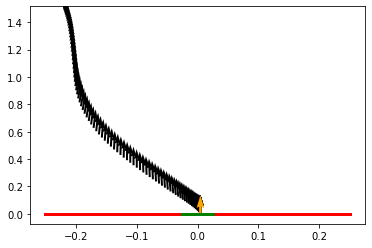

[0.0008285  0.00036051 0.00458094 0.00035801 0.00014488 0.00046778]


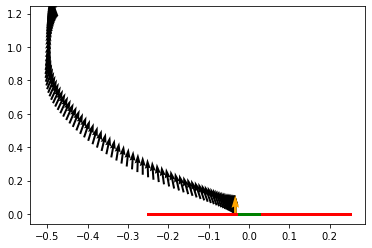

[0.0036327  0.00664519 0.03370639 0.00165415 0.00037127 0.00065332]


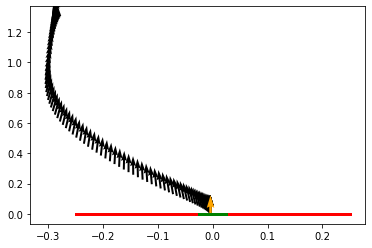

[1.0504101e-04 7.8008609e-04 3.9511570e-03 6.6041008e-05 9.5183532e-05
 2.5728159e-04]


In [350]:
N_eval = 20 # number of initial states for testing
T = 100  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden1 = 12  # latent dimensions
dim_hidden2 = 4  # latent dimensions
dim_output = 2  # action space dimensions
d_eval = Dynamics()  # define dynamics
model_eval =  Controller(dim_input, dim_hidden1, dim_hidden2, dim_output)

path = './Landing_Model.pth'
model_eval.load_state_dict(t.load(path))
model_eval.eval()

s_eval = Simulation(model_eval, d_eval, T, N_eval )
eva = Evaluation(s_eval)  # define optimizer
eva.test(N_eval)

